In [23]:
import requests
import numpy as np
from config import *
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
rc('font', family='AppleGothic')

plt.rcParams['axes.unicode_minus'] = False


In [239]:
def df_plotting(df, title):

    column_idx = df.columns.to_list()
    time_idx = df.index.to_list()

    plt.figure(figsize=(14,8))
    
    for i in column_idx:
        plt.plot(time_idx, df[i], label=i)

    plt.title(title, size=30)
    plt.legend()
    plt.show()

In [183]:
def daily_news_df():
    
    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    query_day = """
    {
    "size": 0,
    "aggs": {
        "group_by_date":{
        "date_histogram": {
            "field": "created_at",
            "interval": "day"
        }
        }
    }
    }
    """

    headers = {
        'Content-Type' : 'application/json'
    }

    resp = requests.get(
        url,
        data=query_day,
        headers=headers,
        auth= ELASTIC_SEARCH_AUTH
    )

    data = resp.json()

    daily = data['aggregations']['group_by_date']['buckets']
    df_daily = pd.DataFrame(data = daily)[['key_as_string', 'doc_count']]
    df_daily = df_daily.rename(columns={"key_as_string" : "date"})
    df_daily['date'] = pd.to_datetime(df_daily['date'])
    df_daily = df_daily.set_index('date')

    return df_daily

In [185]:
df = daily_news_df()

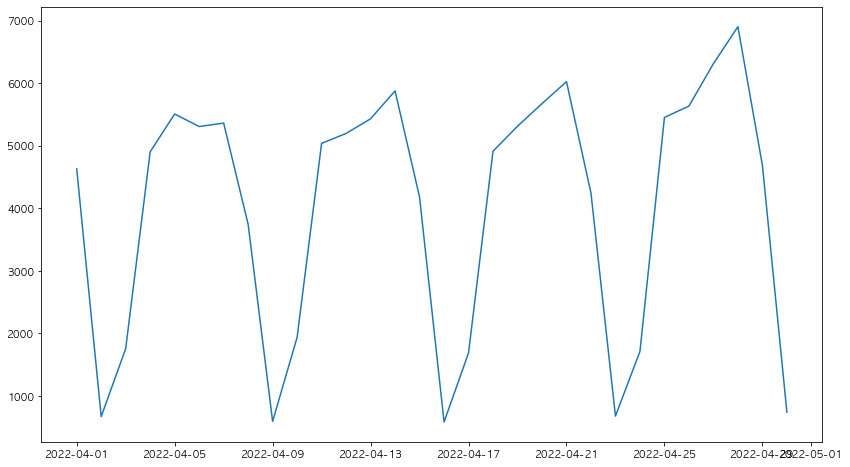

In [206]:
df_plotting(df)

# 2. Top5 언론사 리스트 변수로 받아 각 날짜 별로 언론사 기사 갯수 time-series chart 출력

## Top5 언론사

In [233]:
def top_publisher(num_of_publisher):
    
    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    query_publisher = """
    {
    "size": 0,
    "aggs": {
        "group_by_publisher":{
        "terms": {
            "field": "publisher.keyword",
            "size": %i
        }
        }
    }
    }
    """%int(num_of_publisher)

    headers = {
        'Content-Type' : 'application/json'
    }

    resp = requests.get(
        url,
        data=query_publisher,
        headers=headers,
        auth= ELASTIC_SEARCH_AUTH
    )

    data = resp.json()

    dict = data['aggregations']['group_by_publisher']['buckets']

    df = pd.DataFrame(data=dict)

    # publisher_list = []
    # for i in range(len(dict)):
    #     publisher_list.append(dict[i]['key'])

    return df['key'].to_list()

In [234]:
top_publisher(5)

['연합뉴스', '뉴스1', '뉴시스', '이데일리', '파이낸셜뉴스']

In [232]:
def publisher_daily_news_trend (publisher_list):

    time_idx = daily_news_df().index.to_list()

    df = pd.DataFrame(index=time_idx)

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    headers = {
    'Content-Type' : 'application/json'
    }


    for keyword in publisher_list:
        query = """
            {
                "size": 0,
                "aggs": {
                    "group_by_date":{
                        "date_histogram": {
                            "field": "created_at",
                            "interval": "day"
                        }
                    }
                },
                "query":{
                    "match":{
                    "publisher": "%s"
                    }
                }
            }
        """ %str(keyword)

        resp = requests.get(
            url,
            data=query.encode('utf-8'),
            headers=headers,
            auth= ELASTIC_SEARCH_AUTH
        )

        data = resp.json()
        data = data['aggregations']['group_by_date']['buckets']
        df_tmp = pd.DataFrame(data = data)[['key_as_string', 'doc_count']]
        df_tmp = df_tmp.rename(columns={"key_as_string" : "date"})
        df_tmp['date'] = pd.to_datetime(df_tmp['date'])
        df_tmp = df_tmp.set_index('date')

        df[keyword] = df_tmp['doc_count']


    return df
    

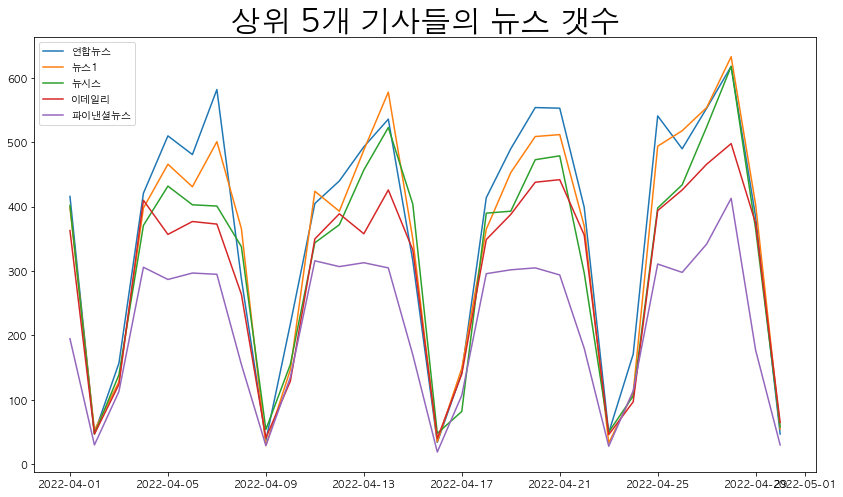

In [240]:
df_plotting(publisher_daily_news_trend(top_publisher(5)), "상위 5개 기사들의 뉴스 갯수")

# 3. 키워드 리스트를 변수로 받아 키워드별 일별 기사 갯수 & 비율 출력

In [250]:
def keyword_daily_news_trend (keyword_list):

    time_idx = daily_news_df().index.to_list()

    df = pd.DataFrame(index=time_idx)

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    headers = {
    'Content-Type' : 'application/json'
    }


    for keyword in keyword_list:
        query = """
            {
                "size": 0,
                "aggs": {
                    "group_by_date":{
                        "date_histogram": {
                            "field": "created_at",
                            "interval": "day"
                        }
                    }
                },
                "query":{
                    "match":{
                    "body": "%s"
                    }
                }
            }
        """ %str(keyword)

        resp = requests.get(
            url,
            data=query.encode('utf-8'),
            headers=headers,
            auth= ELASTIC_SEARCH_AUTH
        )

        data = resp.json()
        data = data['aggregations']['group_by_date']['buckets']
        df_tmp = pd.DataFrame(data = data)[['key_as_string', 'doc_count']]
        df_tmp = df_tmp.rename(columns={"key_as_string" : "date"})
        df_tmp['date'] = pd.to_datetime(df_tmp['date'])
        df_tmp = df_tmp.set_index('date')

        df[keyword] = df_tmp['doc_count']

    
    df = df.fillna(0)

    return df
    

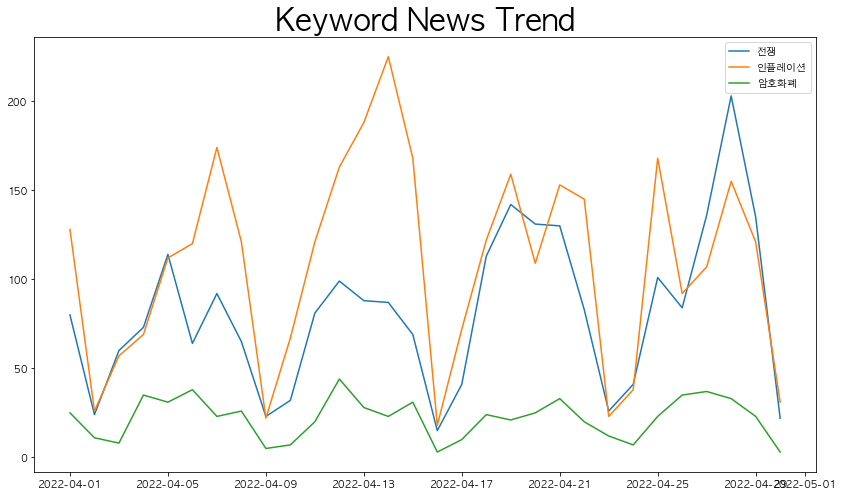

In [254]:
df_plotting(keyword_daily_news_trend(['전쟁', '인플레이션', '암호화폐']), "Keyword News Trend")

# 4. 날짜별로 뉴스 Title 크롤링해서 리스트로 정리

In [263]:
a = '2022-04-05'
dt.datetime.isoformat(dt.datetime.strptime(a, "%Y-%m-%d") + dt.timedelta(days=1))

'2022-04-06T00:00:00'

In [264]:
def title_collect_daily(date):

    date = dt.datetime.isoformat(dt.datetime.strptime(date, "%Y-%m-%d"))
    next_date = dt.datetime.isoformat(dt.datetime.strptime(date, "%Y-%m-%d") + dt.timedelta(days=1))

    url = f"{ELASTIC_SEARCH_URL}/news/_search"

    headers = {
        'Content-Type' : 'application/json'
        }

    query="""{
      "_source": "title",
      "size": 10000,
      "query": {
        "bool": {
          "must": { "match_all": {} },
          "filter": {
            "range": {
              "created_at": {
                "gte": "%s",
                "lt": "%s"
              }
            }
          }
        }
      }
    }"""%str(date, next_date)



    resp = requests.get(
        url,
        data=query,
        headers=headers,
        auth= ELASTIC_SEARCH_AUTH
    )

    data = resp.json()
    data = data['aggregations']['group_by_date']['buckets']

    return data

In [265]:
title_collect_daily('2022-04-05')

ValueError: unconverted data remains: T00:00:00